# 循环生成式对抗网络

## CycleGAN基本原理

CycleGAN（循环对抗生成网络，Cycle Generative Adversarial Networks）是GAN的扩展。

GAN网络对于图片的风格转换是很好的，但是获取成对的训练数据可能是困难和昂贵的。例如，对于语义分割等任务，只有几个数据集存在，而且它们相对较小。获得像艺术风格化这样的图形任务的输入-输出对可能会更加困难，因为所需的输出是非常复杂的，通常需要艺术创作。所以文章里面实现了捕获一个图像集合的特殊特征，并找出这些特征如何转换成另一个图像集合，所有这些都在没有任何成对训练例子的情况下。

其生成器模型参考了Perceptual losses for real-time style transfer and super-resolution这篇论文的网络架构，判别器采用了70×70 PatchGANs[22, 30, 29]结构，相对于GAN其生成器里面利用了多个上卷积下卷积和残差块级联的结合，其基本原理如下所示，相较于传统的GAN网络采用了正向反向GAN网络的循环一致性将其加入了损失函数，同时训练两个方向的GAN网络。

![cyclemodel](./images/model.jpg)

我们在域$X$中得到一组图像，在域$Y$中得到一组不同的图像。我们可以训练一个映射$G：X→Y$，这样输出的$yˆ=G(x)$，$x∈X$，与图像$y∈Y$无法区分。理论上，这个目标可以在$yˆ$上诱导一个输出分布，与经验分布$p_{data(y)}$相匹配(一般来说，这需要$G$是随机的)。因此，最优$G$将域$X$转化为与$Y$相同分布的域$Yˆ$。然而，这样的转换并不能保证单个的输入$x$和输出$y$以一种有意义的方式配对，这会导致有无限多个映射$G$将在$yˆ$上诱导相同的分布。此外，在实践中，我们发现很难孤立地优化对抗性目标。

例如，把一个句子从英语翻译成法语，然后把它从法语翻译回英语，我们应该回到原来的句子。从数学上讲，如果我们有一个翻译$G：X→Y$和另一个翻译$F：Y→X$，那么$G$和$F$应该是相反的，并且两个映射都应该是双射。我们通过将映射G和F同时训练，并增加一个循环一致性损失来激励$F(G(x))\approx x$和$G(F(y))\approx y$。将这种损失与域$X$和$Y$上的对抗性损失相结合，可以得到我们的未配对图像到图像转换的完整目标。

它由Jun-Yan Zhu等人在论文[Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf)中进行描述。判别器由卷积层、BatchNorm层和LeakyRelu激活层以及组成。输入是生成器的的返回参数，输出是一个对应维度的tensor。生成器则是由转置卷积层、BatchNorm层和ReLU激活层以及重要的残差块级联组成。输入是3x256x256（3x128x128），输出是fake_A, fake_B, rec_A, rec_B, identity_A, identity_B。

本教程将使用论文作者提供的taesung_park/CycleGAN数据集来训练一个生成式对抗网络，接着使用该网络进行对应的风格转换。

![cycleresult](./images/result.jpg)

## CycleGAN训练

在下面的教程中，我们将通过示例代码说明如何设置网络、优化器、如何计算损失函数以及如何初始化模型权重。在本教程中，我们使用taesung_park/CycleGAN数据集。首先我们将数据集下载到指定目录下并解压。示例代码如下（同样可以使用提供的sh文件进行下载），horse2zebra数据集进行展示：

### 数据处理

开始实验之前，请确保本地已经安装了Mindspore环境并安装了MindSpore Vision套件。
首先通过args获得默认配置的参数，选择phase参数默认为训练模式，并选择执行模式，在每个模块中重要的参数将会在后面的模块使用中进行介绍。

In [1]:
import os

from mindspore import context

from src.config.cyclegan_config import parse_args


# 这里通过args获取必要参数并且进行执行模式的设置。
args = parse_args("train")

# 选择执行模式为图模式；指定训练使用的平台为"GPU"，如需使用昇腾硬件可将其替换为"Ascend"。
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

args.rank = 0
args.device_num = 1

# 这里在"GPU"模式下，启用图算融合去优化网络。
if args.platform == "GPU":
    context.set_context(enable_graph_kernel=True)

# 如果是在"Ascend"训练平台下，则将填充模式设置为"CONSTANT"。
if args.platform == "Ascend":
    args.pad_mode = "CONSTANT"

# 这里如果batch_size为1，我们设置为"instance"，如果batch_size为其他则设置为"batch"模式，本文章默认为1的效果更加佳。
if args.batch_size == 1:
    args.norm_mode = "instance"

if args.max_dataset_size is None:
    args.max_dataset_size = float("inf")

args.max_epoch = 1  #此处将训练轮次设置为1。
args.n_epochs = min(args.max_epoch, args.n_epochs)
args.n_epochs_decay = args.max_epoch - args.n_epochs

现在进行数据集的下载。

In [ ]:
import os

from mindvision import dataset

dl_path = "./data/"
dl_url = "https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip"
args.dataroot = os.path.join(dl_path, horse2zebra)  #此处指定对应数据集下载路径，修改数据集类型时次数需要一并修改。
dl = dataset.DownLoad()
dl.download_and_extract_archive(url=dl_url, download_path=dl_path)

可以在下载链接中将horse2zebra.zip替换为：

1.apple2orange.zip ,苹果和橘子间的转换。

2.summer2winter_yosemite.zip, 夏天和冬天的转换。

3.monet2photo.zip, monet风格和照片的转换。

4.cezanne2photo.zip, cezanne风格和照片的转换。

5.ukiyoe2photo.zip, ukiyoe风格和照片的转换。

6.vangogh2photo.zip, vangogh风格和照片的转换。

进行其他风格的迁移训练，但需要保证其文件夹包含trainA，trainB，testA，testB，其中test文件是用于进行推理的，如果解压之后没有可以自己自定义图片进行对应的风格转换。数据集的下载地址为：https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets

下载后的数据集目录结构如下：

```text
./data/horse2zebra
├── trainA
├── trainB
├── testA
└── testB
```

接下来对图片数据集读取，进行打散，以及数据增强操作，最终产生数据集

In [2]:
import multiprocessing

import mindspore.dataset as de
import mindspore.dataset.vision.c_transforms as C

from src.process_datasets.dataset import UnalignedDataset
from src.process_datasets.distributedsampler import DistributedSampler


# 以下操作可以通过引用cyclegan_dataset中的create_dataset进行一步完成。
# 此处通过平台核数计算并行工作数以及定义数据增强操作的参数。
cores = multiprocessing.cpu_count()
num_parallel_workers = min(8, int(cores / args.device_num))
mean = [0.5 * 255] * 3
std = [0.5 * 255] * 3

# 这里进行了数据集的加载。
dataset = UnalignedDataset(args.dataroot, args.phase, max_dataset_size=args.max_dataset_size, use_random=args.use_random)

# 这里将数据集进行打乱。
distributed_sampler = DistributedSampler(len(dataset), args.device_num, args.rank, shuffle=args.use_random)

# 这里将数据及进行生成。
ds = de.GeneratorDataset(dataset, column_names=["image_A", "image_B"],
                         sampler=distributed_sampler, num_parallel_workers=num_parallel_workers)

# 这里定义了数据增强，数据裁剪操作，在传参默认使用了use_random，同时将A域B域的图片进行相同的处理。
trans = [
    C.RandomResizedCrop(args.image_size, scale=(0.5, 1.0), ratio=(0.75, 1.333)),
    C.RandomHorizontalFlip(prob=0.5),
    C.Normalize(mean=mean, std=std),
    C.HWC2CHW()
]
ds = ds.map(operations=trans, input_columns=["image_A"], num_parallel_workers=num_parallel_workers)
ds = ds.map(operations=trans, input_columns=["image_B"], num_parallel_workers=num_parallel_workers)

# 此处的batch_size默认设为1，采用实例模式和eval模式保持一致。
ds = ds.batch(args.batch_size, drop_remainder=True)
args.dataset_size = len(dataset)

通过create_dict_iterator函数将数据转换成字典迭代器，然后使用matplotlib模块可视化部分训练数据。

Image shape: (1, 3, 256, 256)


(-0.5, 255.5, 255.5, -0.5)

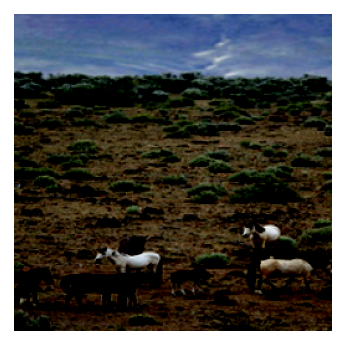

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# 由于本案例训练模式是采用batch_size为1，在可视化中只能显示一张图。
show_data = next(ds.create_dict_iterator())
show_images = show_data["image_A"].asnumpy()
print(f'Image shape: {show_images.shape}')
plt.figure(figsize=(10, 3), dpi=140)

# 展示图片供参考
plt.subplot(1, 1, 1)
show_images[show_images < 0] = 0
plt.imshow(show_images[0].transpose(1, 2, 0))
plt.axis("off")

### 创建网络

当处理完数据后，就可以来进行网络的搭建了。

#### 生成器

生成器本案例采用resnet结构的生成器，由于图片数据集在数据处理过程中默认为处理成256分辨率大小，所以n_layers也默认设置为9，表示了其网络有9个残差块相连，此处来源于文章中说过，对于128的图片采用6个残差块相连，256分辨率以上的采用9个参差块相连。

cyclegan论文论文中生成器结构如下所示：

![cyclegangenerator](./images/generator.jpg)

其具体的参数配置请参照具体代码

我们通过输入部分中设置的`n_layers`和`ngf`来影响代码中的生成器结构。`ngf`是输出通道数也是滤波器数，`n_layers`是级联的残差块数。

以下是生成器的代码实现：

In [4]:
import mindspore.nn as nn
import mindspore.ops as ops

from src.models.convrelu import ConvNormReLU, ConvTransposeNormReLU
from src.models.block import ResidualBlock


# 这里定义了ResNet生成器的网络结构，其中ConvNormReLU, ConvTransposeNormReLU层是定义的卷积以及BatchNorm加上ReLU的一个集合层。
# 此处通过n_layers参数来实现选择几个残差块作为相连，来处理不同尺寸的图片。
class ResNetGenerator(nn.Cell):
    """
    ResNet Generator of GAN.

    Args:
        in_planes (int): Input channel. Default: 3.
        ngf (int): Output channel. Default: 64.
        n_layers (int): The number of ConvNormReLU blocks. Default: 9.
        alpha (float): LeakyRelu slope. Default: 0.2.
        norm_mode (str): Specifies norm method. The optional values are "batch", "instance". Default: "batch".
        dropout (bool): Use dropout or not. Default: False.
        pad_mode (str): Specifies padding mode. The optional values are "CONSTANT", "REFLECT", "SYMMETRIC".
            Default: "CONSTANT".

    Returns:
        Tensor, output tensor.
    """

    def __init__(self, in_planes=3, ngf=64, n_layers=9, alpha=0.2, norm_mode='batch', dropout=False,
                 pad_mode="CONSTANT"):
        super(ResNetGenerator, self).__init__()
        self.conv_in = ConvNormReLU(in_planes, ngf, 7, 1, alpha, norm_mode, pad_mode=pad_mode)
        self.down_1 = ConvNormReLU(ngf, ngf * 2, 3, 2, alpha, norm_mode)
        self.down_2 = ConvNormReLU(ngf * 2, ngf * 4, 3, 2, alpha, norm_mode)
        layers = [ResidualBlock(ngf * 4, norm_mode, dropout=dropout, pad_mode=pad_mode)] * n_layers
        self.residuals = nn.SequentialCell(layers)
        self.up_2 = ConvTransposeNormReLU(ngf * 4, ngf * 2, 3, 2, alpha, norm_mode)
        self.up_1 = ConvTransposeNormReLU(ngf * 2, ngf, 3, 2, alpha, norm_mode)
        if pad_mode == "CONSTANT":
            self.conv_out = nn.Conv2d(ngf, 3, kernel_size=7, stride=1, pad_mode='pad', padding=3)
        else:
            pad = nn.Pad(paddings=((0, 0), (0, 0), (3, 3), (3, 3)), mode=pad_mode)
            conv = nn.Conv2d(ngf, 3, kernel_size=7, stride=1, pad_mode='pad')
            self.conv_out = nn.SequentialCell([pad, conv])
        self.activate = ops.Tanh()

    def construct(self, x):
        x = self.conv_in(x)
        x = self.down_1(x)
        x = self.down_2(x)
        x = self.residuals(x)
        x = self.up_2(x)
        x = self.up_1(x)
        output = self.conv_out(x)
        return self.activate(output)

# 这里定义了实例化生成器以及初始化权重的函数。
def get_generator(args):
    """
    This will implement the CycleGAN model, for learning image-to-image translation without paired data.

    Args:
        in_planes (int): in_planes. Default: 3.
        ngf (int): generator model filter numbers. Default: 64.
        gl_num (int): generator model residual block numbers. Default: 9.
        alpha (float): leakyrelu slope. Default: 0.02.
        norm_mode (str): Specifies norm method. The optional values are "batch", "instance". Default: "batch".
        dropout (bool): Use dropout or not. Default: False.
        pad_mode(str): the type of Pad. The optional values are 'CONSTANT', 'REFLECT', 'SYMMETRIC'. Default: "CONSTANT".
        init_type(str): network initialization. The optional values are 'normal', 'xavier'. Default: 'normal'.
        init_gain(float): scaling factor for normal, xavier and orthogonal. Default: 0.02.

    Returns:
        nn.Cell.
    """

    net = ResNetGenerator(in_planes=args.in_planes, ngf=args.ngf, n_layers=args.gl_num,
                          alpha=args.slope, norm_mode=args.norm_mode, dropout=args.need_dropout,
                          pad_mode=args.pad_mode)
    init_weights(net, args.init_type, args.init_gain)

    return net

# 这里定义了CycleGAN生成器，用来返回用于计算损失函数的各个参数。
class Generator(nn.Cell):
    """
    Generator of CycleGAN, return fake_a, fake_b, rec_a, rec_b, identity_a and identity_b.

    Args:
        g_a (Cell): The generator network of domain a to domain b.
        g_b (Cell): The generator network of domain b to domain a.
        use_identity (bool): Use identity loss or not. Default: True.

    Returns:
        Tensors, fake_a, fake_b, rec_a, rec_b, identity_a and identity_b.

    Examples:
        >>> Generator(g_a, g_b)
    """

    def __init__(self, g_a, g_b, use_identity=True):
        super(Generator, self).__init__()
        self.g_a = g_a
        self.g_b = g_b
        self.ones = ops.OnesLike()
        self.use_identity = use_identity

    def construct(self, img_a, img_b):
        """If use_identity, identity loss will be used."""
        fake_a = self.g_b(img_b)
        fake_b = self.g_a(img_a)
        rec_a = self.g_b(fake_b)
        rec_b = self.g_a(fake_a)
        if self.use_identity:
            identity_a = self.g_b(img_a)
            identity_b = self.g_a(img_b)
        else:
            identity_a = self.ones(img_a)
            identity_b = self.ones(img_b)
        return fake_a, fake_b, rec_a, rec_b, identity_a, identity_b

#### 判别器

如前所述，判别器`D`是一个二分类网络模型，输出判定该图像为真实图的概率。通过一系列的`Conv2d`、`BatchNorm2d`和`LeakyReLU`层对其进行处理，最后通过`Sigmoid`激活函数得到最终概率。

cyclegan论文提到，判别器使用Patch大小为70 * 70的PatchGAN。

判别器的代码实现如下：

In [5]:
import mindspore.nn as nn

from src.models.convrelu import ConvNormReLU
from src.models.utils.init_weight import init_weights


# 这里定义了PatchGAN判别器。
class Discriminator(nn.Cell):
    """
    Discriminator of GAN.

    Args:
        in_planes (int): Input channel. Default: 3.
        ndf (int): discriminator model filter numbers. Default: 64.
        n_layers (int): The number of ConvNormReLU blocks. Default: 3.
        alpha (float): LeakyRelu slope. Default: 0.2.
        norm_mode (str): Specifies norm method. The optional values are "batch", "instance". Default: "batch".

    Returns:
        Tensor, output tensor.

    Examples:
        >>> Discriminator(3, 64, 3)
    """

    def __init__(self, in_planes=3, ndf=64, n_layers=3, alpha=0.2, norm_mode='batch'):
        super(Discriminator, self).__init__()
        kernel_size = 4
        layers = [
            nn.Conv2d(in_planes, ndf, kernel_size, 2, pad_mode='pad', padding=1),
            nn.LeakyReLU(alpha)
        ]
        nf_mult = ndf
        for i in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** i, 8) * ndf
            layers.append(ConvNormReLU(nf_mult_prev, nf_mult, kernel_size, 2, alpha, norm_mode, padding=1))
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8) * ndf
        layers.append(ConvNormReLU(nf_mult_prev, nf_mult, kernel_size, 1, alpha, norm_mode, padding=1))
        layers.append(nn.Conv2d(nf_mult, 1, kernel_size, 1, pad_mode='pad', padding=1))
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output

# 这里定义了初始化权重以及实例化函数。
def get_discriminator(args):
    """
    This will return discriminator by args

    Args:
        in_planes (int): in_planes. Default: 3.
        ndf (int): discriminator model filter numbers. Default: 64.
        gl_num (int): generator model residual block numbers. Default: 9.
        alpha (float): leakyrelu slope. Default: 0.02.
        norm_mode (str): Specifies norm method. The optional values are "batch", "instance". Default: "batch".
        init_type(str): network initialization. The optional values are 'normal', 'xavier'. Default: 'normal'.
        init_gain(float): scaling factor for normal, xavier and orthogonal. Default: 0.02.

    Returns:
        nn.Cell.
    """

    net = Discriminator(in_planes=args.in_planes, ndf=args.ndf, n_layers=args.dl_num,
                        alpha=args.slope, norm_mode=args.norm_mode)
    init_weights(net, args.init_type, args.init_gain)
    return net

#### 损失函数

对于映射函数G：X→Y及其鉴别器DY，我们将目标损失函数定义为:

$$\qquad\qquad\qquad\qquad\qquad L_{GAN}(G,D_Y,X,Y)=E_{y-p_{data}(y)}[logD_Y(y)]+E_{x-p_{data}(x)}[log(1-D_Y(G(x)))]\qquad\qquad\qquad\qquad\qquad\qquad(1)$$

其中G试图生成与域Y的图像相似的图像$G(x)$，而$D_Y$的目的是区分生成样本$G(x)$和真实样本$y$，生成器的目标是最小化这个损失函数以此来对抗判别器。
为了进一步减少可能的映射函数的空间，文章中认为学习到的映射函数应该是周期一致的，例如对于域$X$中的每一个图像$x$，图像平移一个周期映射会原始图像，即$x→G(x)→F(G(x))\approx x$，从而文章采用了一个循环一致性损失来激励这种行为。

$$\qquad\qquad\qquad\qquad\qquad L_{cyc}(G,F)=E_{x-p_{data}(x)}[\Vert F(G(x))-x\Vert_{1}]+E_{y-p_{data}(y)}[\Vert G(F(y))-y\Vert_{1}]\qquad\qquad\qquad\qquad\qquad\qquad(2)$$

文章中提出来的总的损失函数如下，其中包含了正向以及反向GAN网络损失函数，另外加上了一个循环一致性。

$$\qquad\qquad\qquad\qquad\qquad L(G,F,D_X,D_Y)=L_{GAN}(G,D_Y,X,Y)+L_{GAN}(F,D_X,Y,X)+\lambda L_{cyc}(G,F)\qquad\qquad\qquad\qquad\qquad\quad\quad(3)$$

In [6]:
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore.common.dtype as mstype
from mindspore import Tensor
from mindvision.check_param import Validator


# 连接BCEWithLogits损失函数。
class BCEWithLogits(nn.Cell):
    """
    BCEWithLogits creates a criterion to measure the Binary Cross Entropy between the true labels and
    predicted labels with sigmoid logits.

    Args:
        reduction (str): Specifies the reduction to be applied to the output. The optional values are 'none', 'mean', 'sum'. Default: 'none'.

    Outputs:
        Tensor or Scalar.
    """

    def __init__(self, reduction='mean'):
        super(BCEWithLogits, self).__init__()
        if reduction is None:
            reduction = 'none'
        if not reduction:
            Validator.check_string(reduction, ['none', 'mean', 'sum'], "reduction")

        self.loss = ops.SigmoidCrossEntropyWithLogits()
        self.reduce = False
        if reduction == 'sum':
            self.reduce_mode = ops.ReduceSum()
            self.reduce = True
        elif reduction == 'mean':
            self.reduce_mode = ops.ReduceMean()
            self.reduce = True
    def construct(self, predict, target):
        loss = self.loss(predict, target)
        if self.reduce:
            loss = self.reduce_mode(loss)
        return loss

# GAN网络损失函数，这里最后一层不使用sigmod函数。
class GANLoss(nn.Cell):
    """
    The GANLoss class abstracts away the need to create the target label tensor that has the same size as the input.

    Args:
        mode (str): The type of GAN objective. It currently supports 'vanilla', 'lsgan'. Default: 'lsgan'.
        reduction (str): Specifies the reduction to be applied to the output.
            Its value must be one of 'none', 'mean', 'sum'. Default: 'mean'.

    Outputs:
        Tensor or Scalar, if `reduction` is 'none', then output is a tensor and has the same shape as `inputs`.
        Otherwise, the output is a scalar.
    """

    def __init__(self, mode="lsgan", reduction='mean'):
        super(GANLoss, self).__init__()
        self.loss = None
        self.ones = ops.OnesLike()
        if mode == "lsgan":
            self.loss = nn.MSELoss(reduction)
        elif mode == "vanilla":
            self.loss = BCEWithLogits(reduction)
        else:
            raise NotImplementedError(f'GANLoss {mode} not recognized, we support lsgan and vanilla.')

    def construct(self, predict, target):
        target = ops.cast(target, ops.dtype(predict))
        target = self.ones(predict) * target
        loss = self.loss(predict, target)
        return loss

# 这里定义了生成器损失函数。
class GeneratorLoss(nn.Cell):
    """
    Cycle GAN generator loss.

    Args:
        args (class): Option class.
        generator (Cell): Generator of CycleGAN.
        d_a (Cell): The discriminator network of domain a to domain b.
        d_b (Cell): The discriminator network of domain b to domain a.

    Outputs:
        Tuple Tensor, the losses of generator.
    """

    def __init__(self, args, generator, d_a, d_b):
        super(GeneratorLoss, self).__init__()
        self.lambda_a = args.lambda_a
        self.lambda_b = args.lambda_b
        self.lambda_idt = args.lambda_idt
        self.use_identity = args.lambda_idt > 0
        self.dis_loss = GANLoss(args.gan_mode)
        self.rec_loss = nn.L1Loss("mean")
        self.generator = generator
        self.d_a = d_a
        self.d_b = d_b
        self.true = Tensor(True, mstype.bool_)

    def construct(self, img_a, img_b):
        fake_a, fake_b, rec_a, rec_b, identity_a, identity_b = self.generator(img_a, img_b)
        loss_g_a = self.dis_loss(self.d_b(fake_b), self.true)
        loss_g_b = self.dis_loss(self.d_a(fake_a), self.true)
        loss_c_a = self.rec_loss(rec_a, img_a) * self.lambda_a
        loss_c_b = self.rec_loss(rec_b, img_b) * self.lambda_b
        if self.use_identity:
            loss_idt_a = self.rec_loss(identity_a, img_a) * self.lambda_a * self.lambda_idt
            loss_idt_b = self.rec_loss(identity_b, img_b) * self.lambda_b * self.lambda_idt
        else:
            loss_idt_a = 0
            loss_idt_b = 0
        loss_g = loss_g_a + loss_g_b + loss_c_a + loss_c_b + loss_idt_a + loss_idt_b
        return (fake_a, fake_b, loss_g, loss_g_a, loss_g_b, loss_c_a, loss_c_b, loss_idt_a, loss_idt_b)

# 这里定义了判别器的损失函数。
class DiscriminatorLoss(nn.Cell):
    """
    Cycle GAN discriminator loss.

    Args:
        args (class): option class.
        d_a (Cell): The discriminator network of domain a to domain b.
        d_b (Cell): The discriminator network of domain b to domain a.

    Outputs:
        Tuple Tensor, the loss of discriminator.
    """

    def __init__(self, args, d_a, d_b):
        super(DiscriminatorLoss, self).__init__()
        self.d_a = d_a
        self.d_b = d_b
        self.false = Tensor(False, mstype.bool_)
        self.true = Tensor(True, mstype.bool_)
        self.dis_loss = GANLoss(args.gan_mode)
        self.rec_loss = nn.L1Loss("mean")

    def construct(self, img_a, img_b, fake_a, fake_b):
        d_fake_a = self.d_a(fake_a)
        d_img_a = self.d_a(img_a)
        d_fake_b = self.d_b(fake_b)
        d_img_b = self.d_b(img_b)
        loss_d_a = self.dis_loss(d_fake_a, self.false) + self.dis_loss(d_img_a, self.true)
        loss_d_b = self.dis_loss(d_fake_b, self.false) + self.dis_loss(d_img_b, self.true)
        loss_d = (loss_d_a + loss_d_b) * 0.5
        return loss_d

### 封装网络和损失函数

MindSpore将损失函数、优化器等操作都封装到了Cell中，因为GAN结构上的特殊性，其损失是判别器和生成器的多输出形式，这就导致它和一般的分类网络不同。所以我们需要自定义`WithLossCell`类，将网络和Loss连接起来。

In [7]:
# 这里自定义了封装损失和网络模型的类。
class WithLossCell(nn.Cell):
    """
    Wrap the network with loss function to return generator loss.

    Args:
        network (Cell): The target network to wrap.
    """

    def __init__(self, network):
        super(WithLossCell, self).__init__(auto_prefix=False)
        self.network = network

    def construct(self, img_a, img_b):
        lg = (self.network(img_a, img_b))[2]
        return lg

### 训练模型

训练分为两个主要部分：训练判别器和训练生成器，在前文的损失函数（1）中，文章采用了最小二乘损失代替负对数似然目标。

- 训练判别器

   训练判别器的目的是最大程度地提高判别图像真伪的概率。按照文章的方法需要训练判别器来最小化$E_{y-p_{data}(y)}[(D(y)-1)^2]$

- 训练生成器

   如cyclegan论文所述，我们希望通过最小化$E_{x-p_{data}(x)}[(D(G(x)-1)^2]$来训练生成器，以产生更好的虚假图像。

下面定义了生成器和判别器的训练过程：

In [8]:
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore import context
from mindspore.context import ParallelMode
from mindspore.parallel._auto_parallel_context import auto_parallel_context
from mindspore.communication.management import get_group_size


# 这里定义了生成器的训练过程。
class TrainOneStepG(nn.Cell):
    """
    Encapsulation class of Cycle GAN generator network training.
    Append an optimizer to the training network after that the construct
    function can be called to create the backward graph.
    Args:
        g (Cell): Generator with loss Cell. Note that loss function should have been added.
        generator (Cell): Generator of CycleGAN.
        optimizer (Optimizer): Optimizer for updating the weights.
        sens (Number): The adjust parameter. Default: 1.0.
    """

    def __init__(self, g, generator, optimizer, sens=1.0):
        super(TrainOneStepG, self).__init__(auto_prefix=False)
        self.optimizer = optimizer
        self.g = g
        self.g.set_grad()
        self.g.set_train()
        self.g.d_a.set_grad(False)
        self.g.d_a.set_train(False)
        self.g.d_b.set_grad(False)
        self.g.d_b.set_train(False)
        self.grad = ops.GradOperation(get_by_list=True, sens_param=True)
        self.sens = sens
        self.weights = ms.ParameterTuple(generator.trainable_params())
        self.net = WithLossCell(g)
        self.reducer_flag = False
        self.grad_reducer = None
        self.parallel_mode = context.get_auto_parallel_context("parallel_mode")
        if self.parallel_mode in [ParallelMode.DATA_PARALLEL, ParallelMode.HYBRID_PARALLEL]:
            self.reducer_flag = True
        if self.reducer_flag:
            mean = context.get_auto_parallel_context("gradients_mean")
            if auto_parallel_context().get_device_num_is_set():
                degree = context.get_auto_parallel_context("device_num")
            else:
                degree = get_group_size()
            self.grad_reducer = nn.DistributedGradReducer(optimizer.parameters, mean, degree)

    def construct(self, img_a, img_b):
        weights = self.weights
        fake_a, fake_b, lg, lga, lgb, lca, lcb, lia, lib = self.g(img_a, img_b)
        sens = ops.Fill()(ops.DType()(lg), ops.Shape()(lg), self.sens)
        grads_g = self.grad(self.net, weights)(img_a, img_b, sens)
        if self.reducer_flag:
            # apply grad reducer on grads
            grads_g = self.grad_reducer(grads_g)

        return fake_a, fake_b, ops.depend(lg, self.optimizer(grads_g)), lga, lgb, lca, lcb, lia, lib

# 这里定义了判别器的训练过程。
class TrainOneStepD(nn.Cell):
    """
    Encapsulation class of Cycle GAN discriminator network training.
    Append an optimizer to the training network after that the construct
    function can be called to create the backward graph.
    Args:
        G (Cell): Generator with loss Cell. Note that loss function should have been added.
        optimizer (Optimizer): Optimizer for updating the weights.
        sens (Number): The adjust parameter. Default: 1.0.
    """

    def __init__(self, d, optimizer, sens=1.0):
        super(TrainOneStepD, self).__init__(auto_prefix=False)
        self.optimizer = optimizer
        self.d = d
        self.d.set_grad()
        self.d.set_train()
        self.grad = ops.GradOperation(get_by_list=True, sens_param=True)
        self.sens = sens
        self.weights = ms.ParameterTuple(d.trainable_params())
        self.reducer_flag = False
        self.grad_reducer = None
        self.parallel_mode = context.get_auto_parallel_context("parallel_mode")
        if self.parallel_mode in [ParallelMode.DATA_PARALLEL, ParallelMode.HYBRID_PARALLEL]:
            self.reducer_flag = True
        if self.reducer_flag:
            mean = context.get_auto_parallel_context("gradients_mean")
            if auto_parallel_context().get_device_num_is_set():
                degree = context.get_auto_parallel_context("device_num")
            else:
                degree = get_group_size()
            self.grad_reducer = nn.DistributedGradReducer(optimizer.parameters, mean, degree)

    def construct(self, img_a, img_b, fake_a, fake_b):
        weights = self.weights
        ld = self.d(img_a, img_b, fake_a, fake_b)
        sens_d = ops.Fill()(ops.DType()(ld), ops.Shape()(ld), self.sens)
        grads_d = self.grad(self.d, weights)(img_a, img_b, fake_a, fake_b, sens_d)
        if self.reducer_flag:
            grads_d = self.grad_reducer(grads_d)
        return ops.depend(ld, self.optimizer(grads_d))

下面进行模型的训练，实例化损失函数，优化器。本案例训练的是resnet生成器网络，patchGAN判别器。

In [9]:
import os

import mindspore as ms
import mindspore.nn as nn

from src.utils.tools import get_lr, ImagePool, load_ckpt
from src.utils.losses import DiscriminatorLoss, GeneratorLoss
from src.models.cycle_gan import get_generator, get_discriminator, Generator, TrainOneStepG, TrainOneStepD


# 设置种子数为1。
ms.set_seed(1)

# 初始化权重，构建正向反向生成器网络。
g_a = get_generator(args)
g_b = get_generator(args)

# 初始化权重，构建正向反向判别器网络。
d_a = get_discriminator(args)
d_b = get_discriminator(args)

# 是否加载预权重，本案例默认为不需要。
if args.load_ckpt:
    load_ckpt(args, g_a, g_b, d_a, d_b)

# 更新判别器使用生成图像的历史而不是最新生成器生成的图像。文章保留了一个图像缓冲区，用来存储之前创建的50个图像。
imgae_pool_a = ImagePool(args.pool_size)
imgae_pool_b = ImagePool(args.pool_size)

# 实例化生成器。
generator = Generator(g_a, g_b, args.lambda_idt > 0)

# 创建生成器，判别器损失函数。
loss_d = DiscriminatorLoss(args, d_a, d_b)
loss_g = GeneratorLoss(args, generator, d_a, d_b)

# 构建生成器，判别器优化器。
optimizer_g = nn.Adam(generator.trainable_params(), get_lr(args), beta1=args.beta1)
optimizer_d = nn.Adam(loss_d.trainable_params(), get_lr(args), beta1=args.beta1)

# 构建生成器判别器训练过程。
net_g = TrainOneStepG(loss_g, generator, optimizer_g)
net_d = TrainOneStepD(loss_d, optimizer_d)

下面进行训练时的报告生成与保存,以及对生成的图片以及权重文件进行保存

In [10]:
from src.utils.reporter import Reporter


#对数据集进行创建迭代来进行训练，以及保存生成的图片以及权重文件。
data_loader = ds.create_dict_iterator()
reporter = Reporter(args)
reporter.info('==========start training===============')
for _ in range(args.max_epoch):
    reporter.epoch_start()
    for data in data_loader:
        img_a = data["image_A"]
        img_b = data["image_B"]
        res_g = net_g(img_a, img_b)
        fake_a = res_g[0]
        fake_b = res_g[1]
        res_d = net_d(img_a, img_b, imgae_pool_a.query(fake_a), imgae_pool_b.query(fake_b))
        reporter.step_end(res_g, res_d)
        reporter.visualizer(img_a, img_b, fake_a, fake_b)
    reporter.epoch_end(net_g)
    if args.need_profiler:
        profiler.analyse()
        break
reporter.info('==========end training===============')

==========start training===============
Epoch[1] [100/1334] step cost: 1645.77 ms, G_loss: 10.69, D_loss:0.58, loss_G_A: 0.37, loss_G_B: 0.40, loss_C_A: 1.59,loss_C_B: 5.08, loss_idt_A: 0.82, loss_idt_B：2.43
Epoch[1] [200/1334] step cost: 207.61 ms, G_loss: 10.65, D_loss:0.55, loss_G_A: 0.28, loss_G_B: 0.25, loss_C_A: 1.94,loss_C_B: 4.96, loss_idt_A: 0.80, loss_idt_B：2.43
Epoch[1] [300/1334] step cost: 207.62 ms, G_loss: 10.70, D_loss:0.51, loss_G_A: 0.31, loss_G_B: 0.32, loss_C_A: 3.51,loss_C_B: 3.31, loss_idt_A: 1.71, loss_idt_B：1.55
Epoch[1] [400/1334] step cost: 207.71 ms, G_loss: 8.20, D_loss:0.61, loss_G_A: 0.26, loss_G_B: 0.38, loss_C_A: 2.57,loss_C_B: 2.49, loss_idt_A: 1.35, loss_idt_B：1.15
Epoch[1] [500/1334] step cost: 207.64 ms, G_loss: 6.41, D_loss:0.52, loss_G_A: 0.45, loss_G_B: 0.41, loss_C_A: 2.07,loss_C_B: 1.83, loss_idt_A: 0.93, loss_idt_B：0.73
Epoch[1] [600/1334] step cost: 207.92 ms, G_loss: 6.91, D_loss:0.37, loss_G_A: 0.51, loss_G_B: 0.30, loss_C_A: 2.12,loss_C_B: 

为了方便展示，案例中将epoch设置为1，经测试，在实际训练中，将epoch设置为200是一个不错的选择。

## 模型推理

下面进行所训练的模型在测试数据集上的推理以及效果评估，用于推理的图片为数据集testA，testB，训练好的权重可以在此处[cyclegan_ckpt](https://download.mindspore.cn/vision/cyclegan/)进行下载，一种数据集风格迁移有四个ckpt，下载完毕后放到output/ckpt文件里面，或者放在其他位置将args.py文件中的对应路径进行修改对应即可，本案例对应下载horse2zebra的ckpt文件,其文件夹名字为horse。
其中ckpt目录如下所示：

```text
./outputs/ckpt
├── g_a_200.ckpt
├── g_b_200.ckpt
├── d_a_200.ckpt
└── d_b_200.ckpt
```

In [16]:
import os
from mindspore import Tensor

from src.models.cycle_gan import get_generator
from src.utils.reporter import Reporter
from src.utils.tools import save_image, load_ckpt
from src.process_datasets.dataset import create_dataset


# 这几步为模型构建以及加载训练好的权重。此处会有警告，但权重依然正常加载。
args.phase = "predict"
g_a = get_generator(args)
g_b = get_generator(args)
g_a.set_train(False)
g_b.set_train(False)
load_ckpt(args, g_a, g_b)

# 此处为创建推理图片输出位置。
imgs_out = os.path.join(args.outputs_dir, "predict")
if not os.path.exists(imgs_out):
    os.makedirs(imgs_out)
if not os.path.exists(os.path.join(imgs_out, "fake_a")):
    os.makedirs(os.path.join(imgs_out, "fake_a"))
if not os.path.exists(os.path.join(imgs_out, "fake_b")):
    os.makedirs(os.path.join(imgs_out, "fake_b"))

# 此处对正向以及反向推理创建数据集并进行推理以及图片保存。
args.data_dir = 'testA'
ds = create_dataset(args)
reporter.start_predict("A to B")
for data in ds.create_dict_iterator(output_numpy=True):
    img_a = Tensor(data["image"])
    path_a = str(data["image_name"][0], encoding="utf-8")
    path_b = path_a[0:-4] + "_fake_b.jpg"
    fake_b = g_a(img_a)
    save_image(fake_b, os.path.join(imgs_out, "fake_b", path_b))
    save_image(img_a, os.path.join(imgs_out, "fake_b", path_a))
reporter.info('save fake_b at %s', os.path.join(imgs_out, "fake_b", path_a))
reporter.end_predict()
args.data_dir = 'testB'
ds = create_dataset(args)
reporter.dataset_size = args.dataset_size
reporter.start_predict("B to A")
for data in ds.create_dict_iterator(output_numpy=True):
    img_b = Tensor(data["image"])
    path_b = str(data["image_name"][0], encoding="utf-8")
    path_a = path_b[0:-4] + "_fake_a.jpg"
    fake_a = g_b(img_b)
    save_image(fake_a, os.path.join(imgs_out, "fake_a", path_a))
    save_image(img_b, os.path.join(imgs_out, "fake_b", path_b))
reporter.info('save fake_a at %s', os.path.join(imgs_out, "fake_a", path_b))
reporter.end_predict()

[WARNING] ME(8918:139965600003904,MainProcess):2022-07-30-23:05:32.277.660 [mindspore/train/serialization.py:674] For 'load_param_into_net', remove parameter generator.G_A.conv_in.features.0.weight's prefix name: generator.G_A., continue to load it to net parameter conv_in.features.0.weight.
[WARNING] ME(8918:139965600003904,MainProcess):2022-07-30-23:05:32.302.839 [mindspore/train/serialization.py:674] For 'load_param_into_net', remove parameter generator.G_B.conv_in.features.0.weight's prefix name: generator.G_B., continue to load it to net parameter conv_in.features.0.weight.
==========start predict A to B===============
[WARNING] ME(8918:139965600003904,MainProcess):2022-07-30-23:05:32.331.948 [mindspore/dataset/engine/datasets_user_defined.py:756] GeneratorDataset's num_parallel_workers: 8 is too large which may cause a lot of memory occupation (>85%) or out of memory(OOM) during multiprocessing. Therefore, it is recommended to reduce num_parallel_workers to 3 or smaller.
[WARNING

最终的数据结果可以到predict文件夹进行查看，这里展示部分推理的结果，原数据集是A域为普通马匹，B域为斑马。第一幅图为原始A域的图片，第二幅图片为由第一幅图生成的一幅B域的fake斑马图片，第三幅图片为原始B域的图片，第四幅为由第三幅图生成的A域的fake普通马图。

![horse](./images/horse.jpg)


下面是其他一些风格迁移的效果展示:

![style](./images/style.jpg)

![change](./images/change.jpg)


## 总结

本案例对cyclegan的论文中提出的模型进行了详细的解释，向读者完整地展现了该算法的流程。如需查看详细代码，可参考[course仓库](https://toscode.gitee.com/mindspore/course/tree/master/application_example/cyclegan)。

## 引用

[1] Jun-Yan Zhu，Taesung Park，Phillip Isola，Alexei A. Efros Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks[J].arXiv preprint arXiv:1703.10593.pdf
[2] J. Johnson, A. Alahi, and L. Fei-Fei. Perceptual losses for real-time style transfer and super-resolution.In ECCV, 2016.